# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

- [Подготовка данных](#section_1)
- [Обучение моделей](#section_2)
-- [Линейная регрессия](#section_2.1)
-- [Random Forest](#section_2.2)
-- [LightGBM](#section_2.3)
-- [CatBoost](#section_2.4)
- [Анализ моделей](#section_3)
- [Общий вывод](#section_summary)

<a id='section_1'></a>
## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
# последняя дата выгрузки из базы. Необходима для понимания периода, в котором мы работаем
data['DateCrawled'].max()

'2016-04-07 14:36:58'

In [5]:
data = data.drop(columns=['DateCrawled', 'NumberOfPictures', 'LastSeen', 'PostalCode'])

In [6]:
data.duplicated().sum()
data = data.drop_duplicates()

In [7]:
data_len = data.shape[0]

Первым делом уберем неинформативные признаки, которые не описывают характеристика автомобиля, а именно:

**DateCrawled** - дата скачивания анкеты из базы

**NumberOfPictures** - количество фотографий автомобиля

**LastSeen** - дата последней активности пользователя

**PostalCode** — почтовый индекс владельца анкеты (пользователя)


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342535 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              342535 non-null  int64 
 1   VehicleType        305693 non-null  object
 2   RegistrationYear   342535 non-null  int64 
 3   Gearbox            323526 non-null  object
 4   Power              342535 non-null  int64 
 5   Model              323191 non-null  object
 6   Kilometer          342535 non-null  int64 
 7   RegistrationMonth  342535 non-null  int64 
 8   FuelType           310182 non-null  object
 9   Brand              342535 non-null  object
 10  Repaired           272904 non-null  object
 11  DateCreated        342535 non-null  object
dtypes: int64(5), object(7)
memory usage: 34.0+ MB


In [9]:
data.isna().sum()

Price                    0
VehicleType          36842
RegistrationYear         0
Gearbox              19009
Power                    0
Model                19344
Kilometer                0
RegistrationMonth        0
FuelType             32353
Brand                    0
Repaired             69631
DateCreated              0
dtype: int64

In [10]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,342535.000000,342535.000000,342535.000000,342535.000000,342535.000000
mean,4397.944549,2004.224704,109.971717,128226.239654,5.699803
std,4511.488765,91.122800,191.863810,37926.776381,3.729032
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1000.000000,1999.000000,68.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,104.000000,150000.000000,6.000000
75%,6350.000000,2008.000000,141.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


Далее поработаем с признаками, относящимся в времени. **RegistrationYear** и **RegistrationMonth**, по сути, это один признак. Однако сами по себе эти признаки не кажется информативными. Но есть вычесть из признака **DateCreated** дату регистрации объявления, то мы получим возраст автомобиля, после чего перечисленные выше признаки нам уже не нужны.

In [11]:
data['RegistrationYear'].describe()

count    342535.000000
mean       2004.224704
std          91.122800
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

<AxesSubplot:>

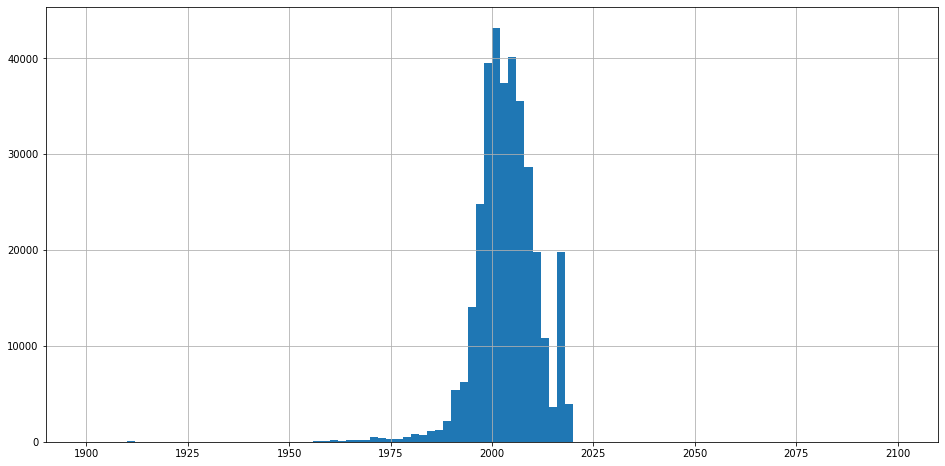

In [12]:
plt.figure(figsize=(16, 8))
data['RegistrationYear'].hist(bins=100, range=(1900, 2100))

In [13]:
data.loc[(data['RegistrationYear'] >= 1980) & (data['RegistrationYear'] <= 2016)].shape[0] / data_len

0.9485220488417242

Машина не может быть зарегестрирована позже, чем текущая выгрузка из базы, берем верхнуюю границу по 2016 год включительно. В качестве нижней границы выбран 1980 год, чтобы оставить ~95% от датасета. Остальные наблюдения считаем выбросами и удаляем.

P.S. Конечно, мы рискуем удалить какой-нибудь реальный раритетный автомобиль более старого года выпуска, но это приложение работает на широкую аудиторию с более обычными вариантами авто. 

In [14]:
data = data.loc[(data['RegistrationYear'] >= 1980) & (data['RegistrationYear'] <= 2016)]

In [15]:
data['RegistrationMonth'].value_counts()

0     32256
3     31777
6     29053
4     27063
5     26890
7     24965
10    24140
12    22490
11    22330
9     22049
1     21356
8     20871
2     19662
Name: RegistrationMonth, dtype: int64

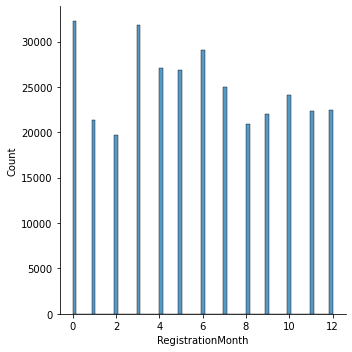

In [16]:
sns.displot(data['RegistrationMonth'], kind='hist')

У нас получилось 13 месяцев. Будум считать, что значение 0 - это если в базе месяц попросту не указан, заполним каким-нибудь

In [17]:
#data.loc[data['RegistrationMonth'] == 0, 'RegistrationMonth'] = 7


In [18]:
probs = data.loc[data['RegistrationMonth']!=0, 'RegistrationMonth'].value_counts().sort_index() \
                                    / data.loc[data['RegistrationMonth']!=0].shape[0]
probs, probs.sum()

(1     0.072976
 2     0.067187
 3     0.108585
 4     0.092477
 5     0.091886
 6     0.099277
 7     0.085308
 8     0.071318
 9     0.075344
 10    0.082489
 11    0.076304
 12    0.076851
 Name: RegistrationMonth, dtype: float64,
 1.0)

In [19]:
M = data.loc[data['RegistrationMonth']==0].shape[0]
res = np.random.choice(range(1, 13), size=M, p=probs)

In [20]:
data.loc[data['RegistrationMonth']==0, 'RegistrationMonth'] = res

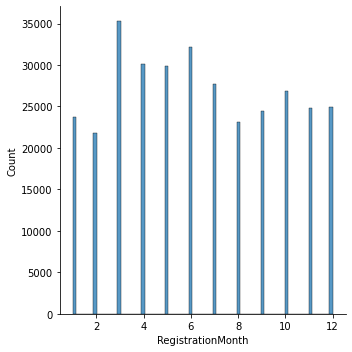

In [21]:
sns.displot(data['RegistrationMonth'], kind='hist')

In [22]:
data['CarAge'] = (pd.to_datetime(data['DateCreated']) - pd.to_datetime(data['RegistrationYear'].astype('str') + ' ' + 
                                                                       data['RegistrationMonth'].astype('str'),
                                                                       format='%Y %m')) / np.timedelta64 ( 1 , 'M') 



<AxesSubplot:>

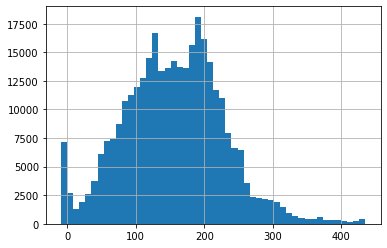

In [23]:
data['CarAge'].hist(bins=50)

In [24]:
data = data.drop(columns=['RegistrationMonth', 'RegistrationYear', 'DateCreated'])

Далее нам нужно посмотреть пропуски в **VehicleType**, **Gearbox**, **Model**, **FuelType**, **Repaired**

In [25]:
data['VehicleType'].value_counts()

sedan          86866
small          76916
wagon          62584
bus            27740
convertible    19093
coupe          15109
suv            11347
other           3068
Name: VehicleType, dtype: int64

In [26]:
data.loc[(~data['Model'].isna()) & (~data['VehicleType'].isna()), ['VehicleType', 'Model', 'Brand']].duplicated().sum()

289309

In [27]:
data.loc[(~data['Model'].isna()) & (~data['VehicleType'].isna()), ['VehicleType', 'Model', 'Brand']].size

872106

Восстановить VehicleType по модели и бренду не получится, придется заполнять другим способом. Предлагаю выделить в отдельную категорию unknown

In [28]:
data['VehicleType'].fillna('unknown', inplace=True)

In [29]:
data['Gearbox'].value_counts()

manual    247088
auto       61380
Name: Gearbox, dtype: int64

Ручная коробка встречается намного чаще, заполним ей

In [30]:
data['Gearbox'].fillna('manual', inplace=True)

In [31]:
data['Model'].fillna('unknown', inplace=True)

In [32]:
data['FuelType'].value_counts()

petrol      200877
gasoline     91960
lpg           4942
cng            529
hybrid         218
other          164
electric        87
Name: FuelType, dtype: int64

In [33]:
data['FuelType'].fillna('petrol', inplace=True)

In [34]:
data['Repaired'].fillna('unknown', inplace=True)

Заполнили пропуски модой или новой категорией

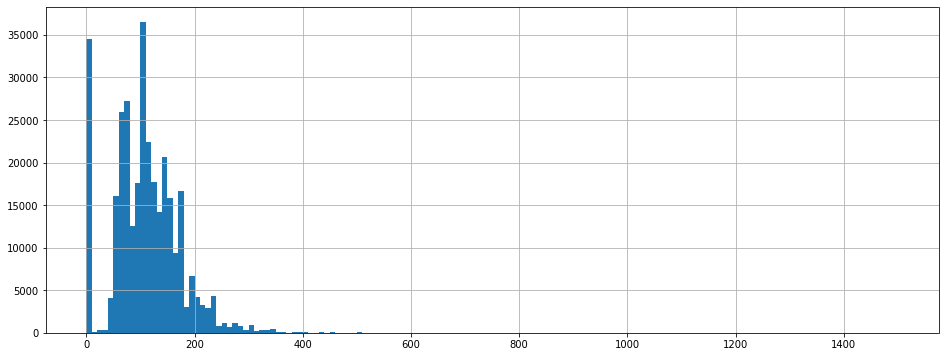

In [35]:
plt.figure(figsize=(16,6))
data['Power'].hist(bins=150, range=(0, 1500))
plt.show()

Нас, очевидно. смущают нулевые значения. Кроме того, есть выбросы справа, которые не объясняются опечаткой (например, лишний ноль в конце), это именно ошибки которые не исправить. Оставляем наблюдения в диапазоне от 20 до 450 (диапазон выбран, исходя беглого поиска реальных машин и их мощности. При этом нулевые значения заполняем медианой по бренду.

In [36]:
#data = data.loc[(data['Power']<=450) & (data['Power']>=20)]
data = data.loc[(data['Power']<=450)]

In [37]:
data.loc[data['Power']==0, 'Power'] = np.nan
data['Power'] = data['Power'].fillna(data.groupby('Brand')['Power'].median())

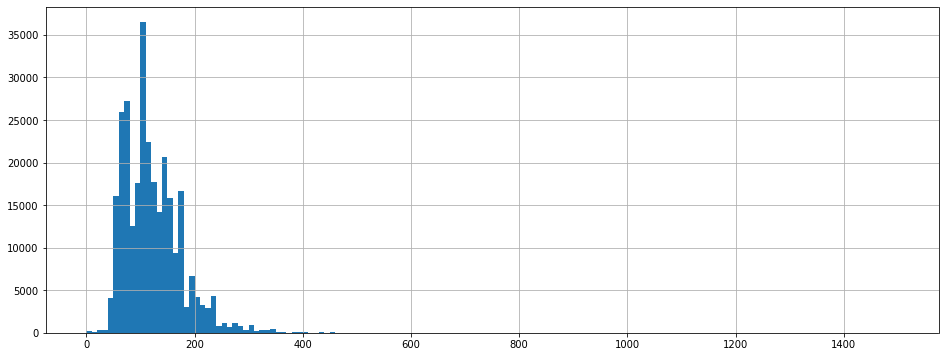

In [38]:
plt.figure(figsize=(16,6))
data['Power'].hist(bins=150, range=(0, 1500))
plt.show()

In [39]:
data = data.loc[data['Power']>20]

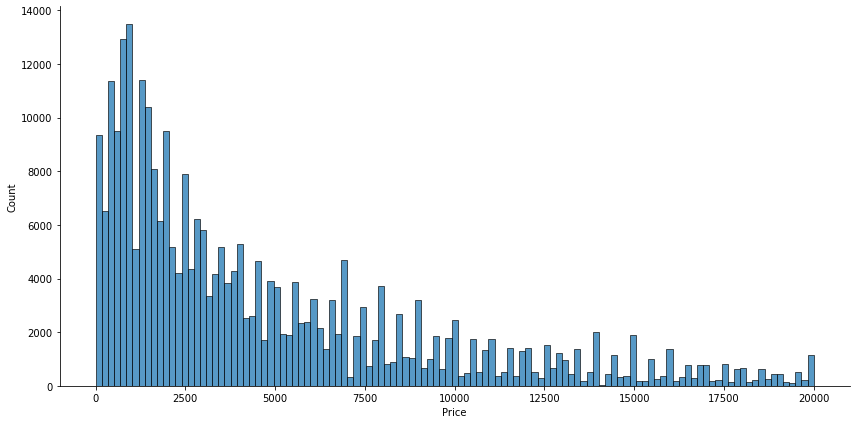

In [40]:
sns.displot(data['Price'], height=6, aspect=2)

**Price** - это наша целевая переменная, менять её по своему усмотрению мы не можем. Удалим наблюдения ниже 50$. То что будет чуть выше данной отметки будем считать металлоломом или продажей на запчасти.

In [41]:
data = data.loc[data['Price']>50]

In [42]:
data.shape[0] / data_len

0.8256149006670851

**Вывод**

Мы ознакомились с датасетом, избавились от пропусков, дубликатов и выбросов, добавили новый признак **Age**.

В результате манипуляций у нас осталось 82% от изходного количества наблюдений.

<a id='section_2'></a>
## Обучение моделей

Мы будем обучать разные модели, в том числе те, которые не умеют работать с категориальными переменными "из коробки", поэтому нужно обработать данные

In [43]:
categorical = data.select_dtypes('object').columns

In [44]:
for column in categorical:
    print(column + ' ', data[column].unique().size)

VehicleType  9
Gearbox  2
Model  249
FuelType  7
Brand  40
Repaired  3


Для признаков Model и Brand слишком много уникальных значений, чтобы использовать OHE.

In [45]:
X = data.drop('Price', axis=1)
y= data['Price']

In [46]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=1)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=1)

X_train.shape, X_valid.shape, X_test.shape

((169681, 9), (56560, 9), (56561, 9))

In [47]:
cols_to_scale = ['Power', 'Model', 'Kilometer', 'Brand', 'CarAge']
cols_to_ohe = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired']
cols_to_ord = ['Model', 'Brand']

In [48]:
transformer = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), cols_to_ohe),
                                      remainder='passthrough')

In [49]:
transformer.fit(X_train)

X_train = pd.DataFrame(transformer.transform(X_train), columns=transformer.get_feature_names())
X_valid = pd.DataFrame(transformer.transform(X_valid), columns=transformer.get_feature_names())
X_test = pd.DataFrame(transformer.transform(X_test), columns=transformer.get_feature_names())

In [50]:
ordinal_encoder = OrdinalEncoder(handle_unknown='ignore')

X_train[cols_to_ord] = ordinal_encoder.fit_transform(X_train[cols_to_ord])
X_valid[cols_to_ord] = ordinal_encoder.transform(X_valid[cols_to_ord])
X_test[cols_to_ord] = ordinal_encoder.transform(X_test[cols_to_ord])

In [51]:
scaler = MinMaxScaler()

X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_valid[cols_to_scale] = scaler.transform(X_valid[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

In [52]:
X_train = X_train.astype('float')
X_valid = X_valid.astype('float')
X_test = X_test.astype('float')

**Промежуточный вывод**

Мы подготовили данные для работы с различными алгоритмами: провели кодирование категориальных переменных, отмасштабировали данные.

Данные разбиты на три выборки: обучающая, валидационная и тестовая. Тестовую будем использовать для проверки наиболее перспективной модели

<a id='section_2.1'></a>
### Линейная регрессия

In [53]:
linear_model = LinearRegression()

In [54]:
time_fit = time.time()
linear_model.fit(X_train, y_train)
time_fit = time.time() - time_fit

In [55]:
time_pred = time.time()
linear_model_pred = linear_model.predict(X_valid)
time_pred = time.time() - time_pred

In [56]:
report = {}
report['Линейная регрессия'] = [time_fit, time_pred, mean_squared_error(y_valid, linear_model_pred, squared=False)]

<a id='section_2.2'></a>
### Random Forest

In [57]:
def fit_model(estimator, params, model_name, verbose=0):
    for depth in params['max_depth']:
        for n_estimators in params['n_estimators']:
            model = estimator(max_depth=depth,
                              n_estimators=n_estimators,
                              random_state=1,
                              verbose=verbose)
            
            time_fit = time.time()
            model.fit(X_train, y_train)
            time_fit = time.time() - time_fit
            
            time_pred = time.time()
            pred = model.predict(X_valid)
            time_pred = time.time() - time_pred
            
            rmse_score = mean_squared_error(y_valid, pred, squared=False)
            
            text = f'{model_name} max_depth: {depth}, n_estimators: {n_estimators}'
            report[text] = [time_fit, time_pred, rmse_score]
            print(text + ': Score: ' + str(rmse_score))

In [58]:
params = {'max_depth': [4, 8, 12],
          'n_estimators': [50, 100, 150]}

In [59]:
fit_model(RandomForestRegressor, params, 'RandomForest')

RandomForest max_depth: 4, n_estimators: 50: Score: 2481.852920581253
RandomForest max_depth: 4, n_estimators: 100: Score: 2485.691350935989
RandomForest max_depth: 4, n_estimators: 150: Score: 2485.415342420286
RandomForest max_depth: 8, n_estimators: 50: Score: 1968.4472959414104
RandomForest max_depth: 8, n_estimators: 100: Score: 1967.816618405089
RandomForest max_depth: 8, n_estimators: 150: Score: 1968.3224376238054
RandomForest max_depth: 12, n_estimators: 50: Score: 1697.3675753299544
RandomForest max_depth: 12, n_estimators: 100: Score: 1695.1100997275232
RandomForest max_depth: 12, n_estimators: 150: Score: 1694.498906151959


<a id='section_2.3'></a>
### LightGBM

In [60]:
fit_model(LGBMRegressor, params, 'LGBMRegressor', verbose=-1)

LGBMRegressor max_depth: 4, n_estimators: 50: Score: 1853.88901531749
LGBMRegressor max_depth: 4, n_estimators: 100: Score: 1739.288820606051
LGBMRegressor max_depth: 4, n_estimators: 150: Score: 1687.2491212131124
LGBMRegressor max_depth: 8, n_estimators: 50: Score: 1713.2324341879746
LGBMRegressor max_depth: 8, n_estimators: 100: Score: 1626.5455812180815
LGBMRegressor max_depth: 8, n_estimators: 150: Score: 1596.3965619719397
LGBMRegressor max_depth: 12, n_estimators: 50: Score: 1708.0172626899948
LGBMRegressor max_depth: 12, n_estimators: 100: Score: 1625.0464816814174
LGBMRegressor max_depth: 12, n_estimators: 150: Score: 1590.7085334164337


<a id='section_2.4'></a>
### CatBoost

In [61]:
fit_model(CatBoostRegressor, params, 'CatBoostRegressor')

CatBoostRegressor max_depth: 4, n_estimators: 50: Score: 1739.2815640222989
CatBoostRegressor max_depth: 4, n_estimators: 100: Score: 1663.226036201329
CatBoostRegressor max_depth: 4, n_estimators: 150: Score: 1638.035062666773
CatBoostRegressor max_depth: 8, n_estimators: 50: Score: 1619.3403730316447
CatBoostRegressor max_depth: 8, n_estimators: 100: Score: 1562.1193123861547
CatBoostRegressor max_depth: 8, n_estimators: 150: Score: 1544.4461843954293
CatBoostRegressor max_depth: 12, n_estimators: 50: Score: 1562.0955398174474
CatBoostRegressor max_depth: 12, n_estimators: 100: Score: 1534.3798551935613
CatBoostRegressor max_depth: 12, n_estimators: 150: Score: 1518.1876130289525


**Вывод**

Мы обучили одну линейную модель, одну модель случайного леса и две модели градиентного бустинга. Для моделей, основанных на деревьях, попробованы несколько наборов гиперпараметров.

<a id='section_3'></a>
## Анализ моделей

In [62]:
result = pd.DataFrame(data=report.values(), 
                      index=report.keys(),
                      columns=['Время обучения', 'Время предсказания', 'RMSE']).sort_values(['RMSE'])

In [63]:
result

,Время обучения,Время предсказания,RMSE
"CatBoostRegressor max_depth: 12, n_estimators: 150",13.161823,0.040478,1518.187613
"CatBoostRegressor max_depth: 12, n_estimators: 100",9.559294,0.029609,1534.379855
"CatBoostRegressor max_depth: 8, n_estimators: 150",4.922008,0.015703,1544.446184
"CatBoostRegressor max_depth: 12, n_estimators: 50",4.819582,0.020334,1562.095540
"CatBoostRegressor max_depth: 8, n_estimators: 100",3.893630,0.013186,1562.119312
"LGBMRegressor max_depth: 12, n_estimators: 150",5.687304,0.602529,1590.708533
"LGBMRegressor max_depth: 8, n_estimators: 150",5.397251,0.603175,1596.396562
"CatBoostRegressor max_depth: 8, n_estimators: 50",2.174603,0.009272,1619.340373
"LGBMRegressor max_depth: 12, n_estimators: 100",4.897708,0.411826,1625.046482
"LGBMRegressor max_depth: 8, n_estimators: 100",5.392518,0.404508,1626.545581


In [64]:
result.loc[result.index.str.contains('Random')].mean()

Время обучения          31.622900
Время предсказания       0.399151
RMSE                  2049.391394
dtype: float64

In [65]:
result.loc[result.index.str.contains('Cat')].mean()

Время обучения           5.131920
Время предсказания       0.018152
RMSE                  1597.901282
dtype: float64

In [66]:
result.loc[result.index.str.contains('LGBM')].mean()

Время обучения           3.950055
Время предсказания       0.381767
RMSE                  1682.263757
dtype: float64

**Вывод**

Быстрее всех обучается и предсказывает модель линейной регрессии, однако её результат ниже порога, который озвучен в условиях проекта.

Самую лучшую метрику RMSE продемонстрировала модель Catboost. Более того, в данной задаче эта же модель показала наилучший результат в скорости предсказания и обучения.

Обучим модель с подобранными параметрами на объедененном датасете из тренировочных и валидационных данных, испытаем на тестовом

In [67]:
X_train = pd.concat([X_train, X_valid], axis=0)

In [68]:
y_train = pd.concat([y_train, y_valid])

In [69]:
best_model = CatBoostRegressor(max_depth=12, n_estimators=150, random_state=1, verbose=0)
best_model.fit(X_train, y_train)

best_model_pred = best_model.predict(X_test)

mean_squared_error(y_test,
                   best_model_pred,
                   squared=False)

1488.9654927045842

Метрика качества практически не отличается от результата на валиде, значит наша модель не переобучилась и дает стабильный результат.

<a id='section_summary'></a>
**Общий вывод**

Мы получили данные сервиса по продаже автомобилей. Изучив их, нашли и избавились от признаков, которые не несут смысловой нагрузки и не влияют на стоимость автомобиля.

Исходя их временных признаков, мы очистили датасет от сомнительных наблюдений. Данные, которые невозможно достоверно восстановить, были заполнены новой категорией unknown, либо были удалены, исходя из масштабов пропусков.

Данные были подготовлены к работе разными алгоритмамы машинного обучения.

Из четырех выбранных моделей три смогли преодолеть требуемую заказчиком метрику качества.

Из них в качестве "боевой" я рекомендую Catboost, как наиболее точную и быструю